In [1]:
!git clone https://github.com/zhongzishi/KGCN-movielens.git
%cd /content/KGCN-movielens/

Cloning into 'KGCN-movielens'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 39 (delta 14), reused 32 (delta 7), pack-reused 0
Unpacking objects: 100% (39/39), 3.29 MiB | 2.46 MiB/s, done.
/content/KGCN-movielens


In [2]:
import pandas as pd
import numpy as np
import argparse
import random
from model import KGCN
from data_loader import DataLoader
from main import download_zip, convert_dat, KGCNDataset
import torch
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import time

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument('--data_url', type=str,
                    default='http://files.grouplens.org/datasets/movielens/ml-10m.zip',
                    help='link to download ratings data')
parser.add_argument('--aggregator', type=str, default='sum')
parser.add_argument('--n_epochs', type=int, default=20)
parser.add_argument('--neighbor_sample_size', type=int, default=8)
parser.add_argument('--dim', type=int, default=16, help='dimension of user and entity embeddings')
parser.add_argument('--n_iter', type=int, default=1,
                    help='number of iterations when computing entity representation')
parser.add_argument('--batch_size', type=int, default=65536, help='batch size')
parser.add_argument('--l2_weight', type=float, default=1e-4, help='weight of l2 regularization')
parser.add_argument('--lr', type=float, default=5e-4, help='learning rate')
parser.add_argument('--ratio', type=float, default=0.8, help='size of training dataset')
parser.add_argument('--seed', type=int, default=999, help='seed to split train test set')
args = parser.parse_args(['--l2_weight', '1e-4'])

In [4]:
DATA_PATH = "./data/movie"
RATINGS_COLS = ["userId", "movieId", "rating", "timestamp"]
MOVIE_COLS = ["movieId", "title", "genres"]

In [5]:
# download & transform data
download_zip(args.data_url)
convert_dat(f"{DATA_PATH}/ratings.dat", RATINGS_COLS)
convert_dat(f"{DATA_PATH}/movies.dat", MOVIE_COLS)

Download and transformation done


/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


./data/movie/ratings.csv saved
./data/movie/movies.csv saved


In [6]:
# prepare dataset
data_loader = DataLoader()
kg = data_loader.load_kg()
df_dataset = data_loader.load_dataset()
x_train, x_test, y_train, y_test = train_test_split(df_dataset,
                                                    df_dataset['label'],
                                                    test_size=1 - args.ratio,
                                                    shuffle=False,
                                                    random_state=args.seed)
train_dataset = KGCNDataset(x_train)
test_dataset = KGCNDataset(x_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size, pin_memory=True)

Construct knowledge graph ... Done
Build dataset ... Done


In [7]:
# prepare network, loss function, optimizer
num_user, num_entity, num_relation = data_loader.get_num()
user_encoder, entity_encoder, relation_encoder = data_loader.get_encoders()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = KGCN(num_user, num_entity, num_relation, kg, args, device).to(device)
criterion = torch.nn.BCELoss()
optimizer = optim.Adam(net.parameters(),
                        lr=args.lr,
                        weight_decay=args.l2_weight)

In [8]:
# train
loss_list = []
test_loss_list = []
auc_score_list = []

for epoch in range(args.n_epochs):
    print(f"start {epoch} epoch")
    running_loss = 0.0
    for i, (user_ids, item_ids, labels) in enumerate(train_loader):
        user_ids, item_ids, labels = user_ids.to(device), item_ids.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(user_ids, item_ids)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # print train loss per every epoch
    print('[Epoch {}]train_loss: '.format(epoch + 1), running_loss / len(train_loader))
    loss_list.append(running_loss / len(train_loader))

    # evaluate per every epoch
    with torch.no_grad():
        test_loss = 0
        total_roc = 0
        for user_ids, item_ids, labels in test_loader:
            user_ids, item_ids, labels = user_ids.to(device), item_ids.to(device), labels.to(device)
            outputs = net(user_ids, item_ids)
            test_loss += criterion(outputs, labels).item()
            total_roc += roc_auc_score(labels.cpu().detach().numpy(), outputs.cpu().detach().numpy())
        print('[Epoch {}]test_loss: '.format(epoch + 1), test_loss / len(test_loader))
        test_loss_list.append(test_loss / len(test_loader))
        auc_score_list.append(total_roc / len(test_loader))

start 0 epoch
[Epoch 1]train_loss:  0.741262961407097
[Epoch 1]test_loss:  0.562751111984253
start 1 epoch
[Epoch 2]train_loss:  0.46101245892291165
[Epoch 2]test_loss:  0.3794023525714874
start 2 epoch
[Epoch 3]train_loss:  0.32493701485954984
[Epoch 3]test_loss:  0.27935136198997496
start 3 epoch
[Epoch 4]train_loss:  0.24634869761612951
[Epoch 4]test_loss:  0.21821672856807708
start 4 epoch
[Epoch 5]train_loss:  0.19666369821952315
[Epoch 5]test_loss:  0.17827387332916259
start 5 epoch
[Epoch 6]train_loss:  0.163680299204223
[Epoch 6]test_loss:  0.15132788717746734
start 6 epoch
[Epoch 7]train_loss:  0.14105360544457726
[Epoch 7]test_loss:  0.13245533525943756
start 7 epoch
[Epoch 8]train_loss:  0.12503480029349423
[Epoch 8]test_loss:  0.11893963724374772
start 8 epoch
[Epoch 9]train_loss:  0.1134345468361767
[Epoch 9]test_loss:  0.10896438717842102
start 9 epoch
[Epoch 10]train_loss:  0.10477814344423157
[Epoch 10]test_loss:  0.10149801760911942
start 10 epoch
[Epoch 11]train_loss:

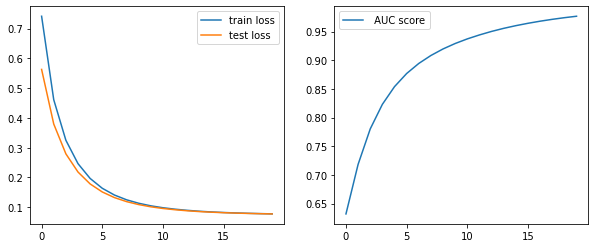

In [9]:
ts = int(time.time())

# plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(loss_list, label="train loss")
ax1.plot(test_loss_list, label="test loss")
ax2.plot(auc_score_list, label=" AUC score")
ax1.legend(loc="upper right")
ax2.legend(loc="upper left")
plt.show()
fig.savefig(f"./kgcn_{ts}.png")

In [10]:
auc_score_list

[0.6319353022913244,
 0.7184098728408681,
 0.7802593037934727,
 0.8231518274911654,
 0.8540352664747292,
 0.8769456018346774,
 0.8945152593353969,
 0.9084219135531795,
 0.9198379981113888,
 0.9293364411503385,
 0.9373762760393624,
 0.94429021500132,
 0.9504358180928908,
 0.9558033450100535,
 0.9604697476136985,
 0.964603087386029,
 0.9682695018100315,
 0.9715056420849488,
 0.9743789560376697,
 0.9768973350941681]

In [11]:
# save model

model_path = f"./kgcn_{ts}.pt"
torch.save(net.state_dict(), model_path)
print(f"model saved : {model_path}")

model saved : ./kgcn_1677973656.pt
